# Credit Default Risk


## Imports


In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Read in Data 

In [2]:
from sklearn.model_selection import train_test_split
# Training data
application_cleaned = pd.read_csv('application_trunc.csv')
app_train_feat, app_test_feat = train_test_split(application_cleaned, test_size=0.15, random_state=42)
# Separate the target variable from the testing set
target_variable = 'TARGET'
app_test_feat_target = app_test_feat[target_variable]
app_test_feat = app_test_feat.drop(target_variable, axis=1)

# Print the shapes of the resulting dataframes
print('Training data shape: ', app_train_feat.shape)
print('Testing shape: ', app_test_feat.shape)
print('Testing target shape: ', app_test_feat_target.shape)


Training data shape:  (85283, 122)
Testing shape:  (15051, 121)
Testing target shape:  (15051,)


# Exploratory Data Analysis

## Examine the Distribution of the Target Column

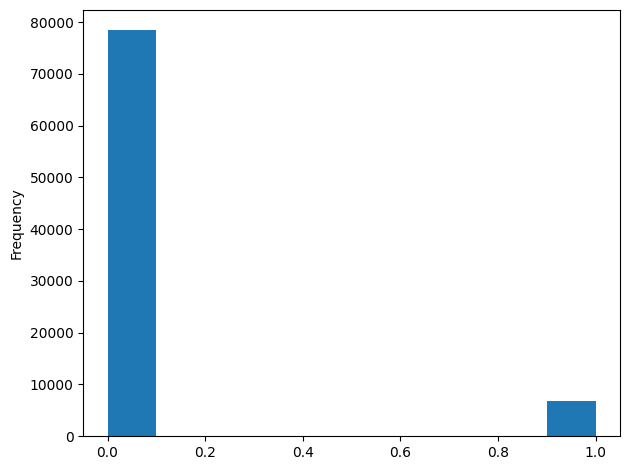

In [3]:
app_train_feat['TARGET'].astype(int).plot.hist()
plt.tight_layout()
plt.savefig("Target distribution.png")

From this information, we see this is an [_imbalanced class problem_](http://www.chioka.in/class-imbalance-problem/). There are far more loans that were repaid on time than loans that were not repaid. Once we get into more sophisticated machine learning models, we can [weight the classes](http://xgboost.readthedocs.io/en/latest/parameter.html) by their representation in the data to reflect this imbalance. 

## Encoding Categorical Variables

### Label Encoding and One-Hot Encoding

In [4]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train_feat:
    if app_train_feat[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train_feat[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train_feat[col])
            # Transform both training and testing data
            app_train_feat[col] = le.transform(app_train_feat[col])
            app_test_feat[col] = le.transform(app_test_feat[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [5]:
# one-hot encoding of categorical variables
app_train_feat = pd.get_dummies(app_train_feat)
app_test_feat = pd.get_dummies(app_test_feat)
train_labels = app_train_feat['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train_feat, app_test_feat = app_train_feat.align(app_test_feat, join = 'inner', axis = 1)

# Add the target back in
app_train_feat['TARGET'] = train_labels


# Create an anomalous flag column
app_train_feat['DAYS_EMPLOYED_ANOM'] = app_train_feat["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train_feat['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)


app_test_feat['DAYS_EMPLOYED_ANOM'] = app_test_feat["DAYS_EMPLOYED"] == 365243
app_test_feat["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)
print('Training Features shape: ', app_train_feat.shape)
print('Testing Features shape: ', app_test_feat.shape)
print('There are %d anomalies in the test data out of %d entries' % (app_test_feat["DAYS_EMPLOYED_ANOM"].sum(), len(app_test_feat)))

Training Features shape:  (85283, 239)
Testing Features shape:  (15051, 238)
There are 2672 anomalies in the test data out of 15051 entries


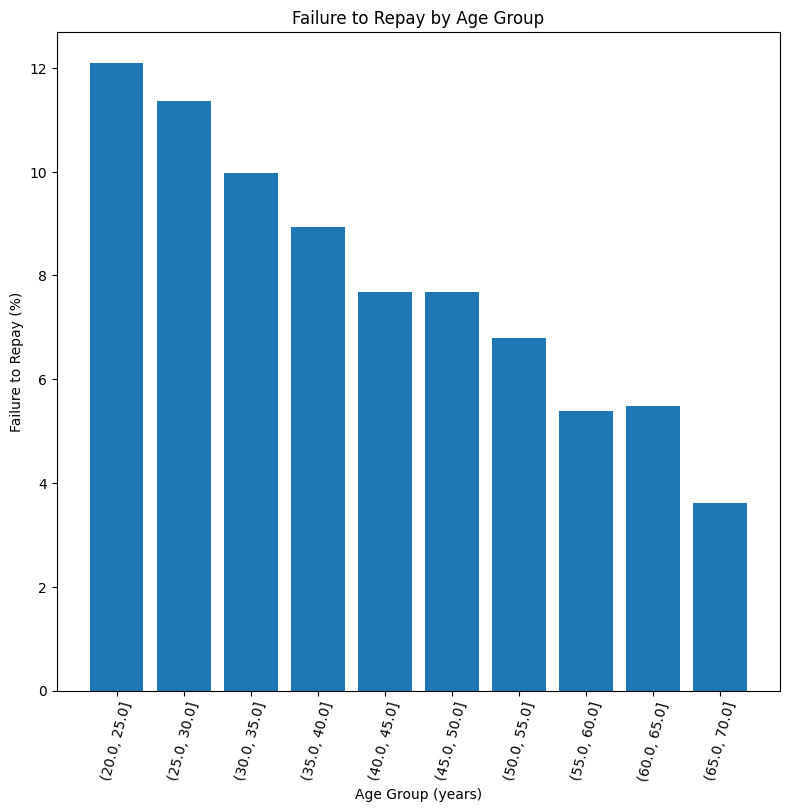

In [6]:
# Age information into a separate dataframe
app_train_feat['DAYS_BIRTH'] = abs(app_train_feat['DAYS_BIRTH'])
app_train_feat['YEARS_BIRTH'] = app_train_feat['DAYS_BIRTH'] / 365

# Bin the age data
app_train_feat['YEARS_BINNED'] = pd.cut(app_train_feat['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))

plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(app_train_feat.groupby('YEARS_BINNED').mean().index.astype(str), 100 * app_train_feat.groupby('YEARS_BINNED').mean()['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.tight_layout()
plt.savefig("Failure to repay by age group.png")

plt.title('Failure to Repay by Age Group')
app_train_feat = app_train_feat.drop(columns=['YEARS_BINNED', 'YEARS_BIRTH'])

Text(0.5, 1.0, 'Correlation Heatmap')

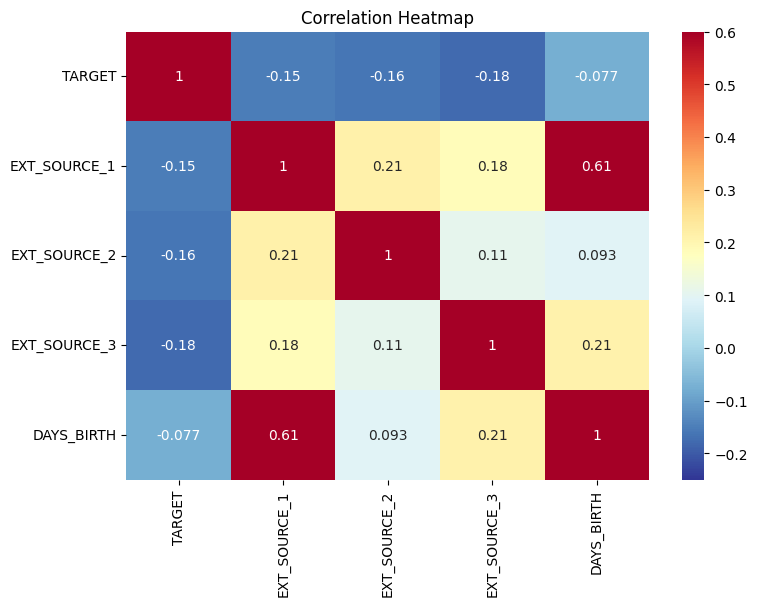

In [7]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(app_train_feat[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']].corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.tight_layout()
plt.savefig("Correlation.png")

plt.title('Correlation Heatmap')

# Feature Engineering

## Create some domain features

In [8]:

app_train_feat['CREDIT_INCOME_PERCENT'] = app_train_feat['AMT_CREDIT'] / app_train_feat['AMT_INCOME_TOTAL']
app_train_feat['ANNUITY_INCOME_PERCENT'] = app_train_feat['AMT_ANNUITY'] / app_train_feat['AMT_INCOME_TOTAL']
app_train_feat['CREDIT_TERM'] = app_train_feat['AMT_ANNUITY'] / app_train_feat['AMT_CREDIT']
app_train_feat['DAYS_EMPLOYED_PERCENT'] = app_train_feat['DAYS_EMPLOYED'] / app_train_feat['DAYS_BIRTH']

In [9]:
app_test_feat['CREDIT_INCOME_PERCENT'] = app_test_feat['AMT_CREDIT'] / app_test_feat['AMT_INCOME_TOTAL']
app_test_feat['ANNUITY_INCOME_PERCENT'] = app_test_feat['AMT_ANNUITY'] / app_test_feat['AMT_INCOME_TOTAL']
app_test_feat['CREDIT_TERM'] = app_test_feat['AMT_ANNUITY'] / app_test_feat['AMT_CREDIT']
app_test_feat['DAYS_EMPLOYED_PERCENT'] = app_test_feat['DAYS_EMPLOYED'] / app_test_feat['DAYS_BIRTH']

# Baseline


## Random Forest


In [10]:
from sklearn.impute import SimpleImputer

# Drop the target from the training data
if 'TARGET' in app_train_feat:
    train_no_missing = app_train_feat.drop(columns = ['TARGET'])

features = list(train_no_missing.columns)

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')
# Fit on the training data
imputer.fit(train_no_missing)

# Transform both training and testing data
train_no_missing = pd.DataFrame(imputer.transform(train_no_missing), columns=features).set_index('SK_ID_CURR')
test_no_missing = pd.DataFrame(imputer.transform(app_test_feat), columns=features).set_index('SK_ID_CURR')



In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, min_samples_leaf=0.01, n_jobs = -1)
features = list(train_no_missing.columns)
# Train on the training data
random_forest.fit(train_no_missing, train_labels)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_

# Make predictions on the test data
predictions = random_forest.predict_proba(test_no_missing)[:, 1]

auc = roc_auc_score(app_test_feat_target.values, predictions)

In [12]:
auc

0.7185794091928855

## Model Interpretation: Feature Importances

In [13]:
def plot_feature_importances(features, feature_importance_values):
    
    df = pd.DataFrame({'feature': features, 'importance': feature_importance_values}).sort_values('importance', ascending = False).reset_index()
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); 
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.savefig('Feature Importances.png')
    plt.show()

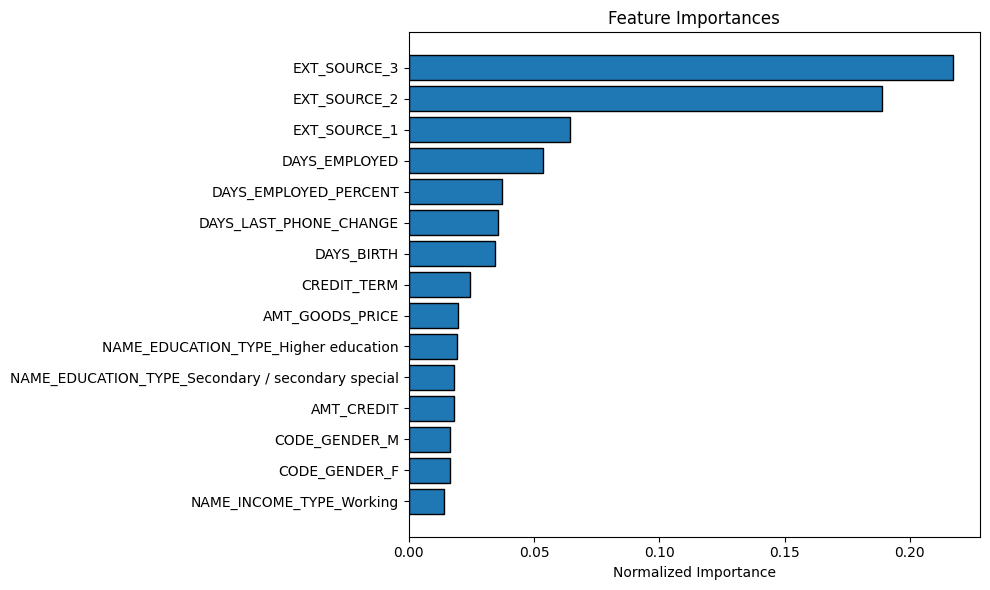

In [14]:
# Show the feature importances for the default features
plot_feature_importances(features, random_forest.feature_importances_)

In [15]:
from vectice import autolog
autolog.config(api_token="Pr1XPn1zB.ngOyML3xnDoWkjZ0Jm6GNPr1XPn1zBAQEvwe8dl7bpaYR9X2V4", phase="PHA-3559")
autolog.notebook("First baseline for Random Forest probability of default classifier")

Phase 'Modeling' successfully retrieved.

For quick access to the Phase in the Vectice web app, visit:
https://app.vectice.com/browse/phase/PHA-3559
Welcome, Eric Barre. You`re now successfully connected to Vectice.
New Iteration number 6 created.

For quick access to the Iteration in the Vectice web app, visit:
https://app.vectice.com/browse/iteration/ITR-6689
Note logged in iteration 6.
File: application_trunc.csv wrapped successfully.
Statistics are only captured for the first 100 columns of your dataframe.
Dataset 'PHA-3559-application_cleaned' logged in iteration 6.
Statistics are only captured for the first 100 columns of your dataframe.
Dataset 'PHA-3559-app_test_feat' logged in iteration 6.
Statistics are only captured for the first 100 columns of your dataframe.
Dataset 'PHA-3559-app_train_feat' logged in iteration 6.
Statistics are only captured for the first 100 columns of your dataframe.
Dataset 'PHA-3559-app_test_feat' logged in iteration 6.
Statistics are only captured fo